<a href="https://colab.research.google.com/github/Wang-Ruhua/WatchReview/blob/main/Unsupervised_Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Sentiment Analysis Project - Watch Review

## Contents

* [Part 1: Load Data and Preprocessing](#Part-1:-Load-Data-and-Preprocessing)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-Means](#Part-4:-K-Means)
* [Part 5: Latent Dirichlet Allocation](#Part-5:-Latent-Dirichlet-Allocation)


# Part 0: Setup PyDrive

In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive2

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = "114JDwymUh06_5bLUm71lMNxHQr4zoP6G"

file = drive.CreateFile({'id':id})
file.GetContentFile('watch_review_data.tsv')

# Part 1: Load Data and Preprocessing

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load data
df = pd.read_csv('watch_review_data.tsv', sep='\t', on_bad_lines='skip')

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [ ]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960191 non-null  object
 13  review_body        960045 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [ ]:
# Check duplications
duplicated_rows = df.duplicated()
num_duplicated = len(df[duplicated_rows])
print(f"Number of duplicated rows is: {num_duplicated}")

Number of duplicated rows is: 0


In [ ]:
# Remove missing valueS
df.dropna(subset=['review_body'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Get the first 1000 data points as training data
data = df.loc[:999, 'review_body'].tolist()

In [ ]:
data[:5]

['Absolutely love this watch! Get compliments almost every time I wear it. Dainty.',
 'I love this watch it keeps time wonderfully.',
 'Scratches',
 'It works well on me. However, I found cheaper prices in other places after making the purchase',
 "Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch"]

# Part 2: Tokenizing and Stemming

In [ ]:
# Create stopwords want to remove
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append('br')
stopwords.append('nt')
stopwords.append('watch')

print(f"Total of {len(stopwords)} stop-words:")

Total of 183 stop-words:


In [ ]:
from nltk.stem.snowball import SnowballStemmer
import re

stemmer = SnowballStemmer("english")

# Function to perform tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # Tokenize the document and remove stop words
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []

    # Remove numbers and punctuations
    for token in tokens:
        token = re.sub(r'[^\w\s]', '', token)
        token = re.sub(r'\d', '', token)
        if token.isalpha():
            filtered_tokens.append(token)

    # Stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


In [ ]:
data[0]

'Absolutely love this watch! Get compliments almost every time I wear it. Dainty.'

In [ ]:
tokenization_and_stemming(data[0])

['absolut',
 'love',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'wear',
 'dainti']

# Part 3: TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf = True, tokenizer = tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data)

print(f"Total of {tfidf_matrix.shape[0]} reviews and {tfidf_matrix.shape[1]} terms.")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  war

Total of 1000 reviews and 246 terms.


In [ ]:
# Get feature terms
terms = tfidf_model.get_feature_names_out()

In [ ]:
# Print top 10 terms with highest TF-IDF values
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=terms)
term_tfidf_sums = tfidf_df.sum(axis=0)
sorted_terms = term_tfidf_sums.sort_values(ascending=False)
print("Top 10 terms with highest TF-IDF:")
print(sorted_terms.head(10))

Top 10 terms with highest TF-IDF:
good     77.480224
love     70.919924
great    65.305737
nice     63.462286
look     54.294494
work     39.377391
like     38.204582
band     35.592039
time     35.382583
nt       32.798211
dtype: float64


# Part 4: K-Means

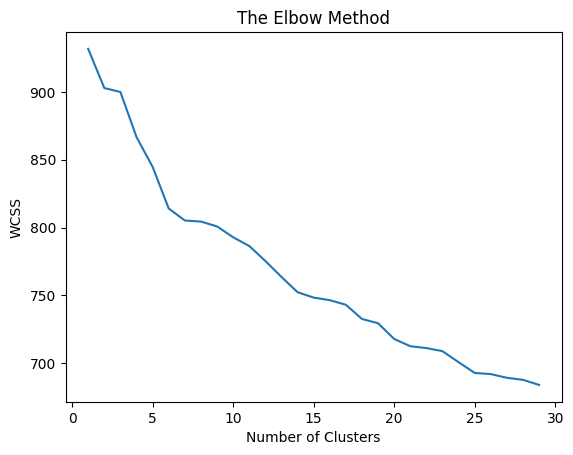

In [ ]:
# Perform the elbow method to find optimal k
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=123)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 30), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
k = 5
km = KMeans(n_clusters=k)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
# create DataFrame films from all of the input files.
product = {'review': df.loc[:999, 'review_body'], 'cluster': clusters}
df_clusters = pd.DataFrame(product)

In [ ]:
df_clusters.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,2
1,I love this watch it keeps time wonderfully.,2
2,Scratches,4
3,"It works well on me. However, I found cheaper ...",4
4,Beautiful watch face. The band looks nice all...,4
5,"i love this watch for my purpose, about the pe...",2
6,"for my wife and she loved it, looks great and ...",3
7,I was about to buy this thinking it was a Swis...,4
8,Watch is perfect. Rugged with the metal &#34;B...,3
9,Great quality and build.<br />The motors are r...,4


In [ ]:
print("Number of reviews included in each cluster:")
df_clusters['cluster'].value_counts()

Number of reviews included in each cluster:


,count
cluster,
4,665
2,110
3,94
0,71
1,60


In [ ]:
# Print top 5 words with highest TF-IDF values of each cluster center
# Print first 5 reviews of each cluster
rank = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}
for i in range(k):
    keywords = []
    print(f"Cluster {i} key words:", end=' ')
    Cluster_keywords_summary[i] = []
    for index in rank[i, :10]:
        print(terms[index], end=' ')
    print()

    cluster_reviews = df_clusters[df_clusters.cluster==i].review
    print(f"Cluster {i} reviews: ", end=' ')
    print(' | '.join(cluster_reviews[:10]))
    print()

Cluster 0 key words: good product price qualiti love work look big excel seller 
Cluster 0 reviews:  very good | It's a good value, and a good functional watch strap.  It's super wide though, and takes more space on the wrist than I'd like. | very good | Excellent product and seller very good service | Good value product | Looks good. Not bulky. Keeps good time. | good | Love the Watch. Good Deal and works Good.. :-) | works good so far. | good

Cluster 1 key words: nice price look realli simpl good seller love light great 
Cluster 1 reviews:  Nice watch, on time delivery from seller. | It works well with nice simple look. | vary nice | Very nice watch !!! | nice watch what you see on the picture is what you get | Very nice watch for running | Nice | Nice | Good Nice watch | Nice desing. I love this watch.

Cluster 2 key words: love wife husband look beauti absolut gift bought color son 
Cluster 2 reviews:  Absolutely love this watch! Get compliments almost every time I wear it. Dainty

# Part 5: Latent Dirichlet Allocation

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5)
lda_output = lda.fit_transform(tfidf_matrix)
topic_word = lda.components_

In [ ]:
# Column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# Index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# Assign topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.06,0.06,0.06,0.36,0.46,4
Doc1,0.08,0.08,0.08,0.08,0.66,4
Doc2,0.10,0.10,0.60,0.10,0.10,2
Doc3,0.54,0.06,0.06,0.28,0.06,0
Doc4,0.04,0.16,0.04,0.72,0.04,3
Doc5,0.08,0.07,0.07,0.08,0.70,4
Doc6,0.07,0.06,0.35,0.06,0.46,4
Doc7,0.06,0.06,0.06,0.75,0.06,3
Doc8,0.04,0.77,0.10,0.04,0.04,1
Doc9,0.06,0.06,0.15,0.68,0.06,3


In [ ]:
df_document_topic['topic'].value_counts()

,count
topic,
3,299
0,202
4,201
1,151
2,147


In [ ]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model, lda, n_words=10)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,good,nice,look,beauti,price,love,qualiti,realli,fine,far
Topic 1,expect,love,awesom,look,pretti,realli,color,want,feel,lot
Topic 2,great,work,excel,product,price,fast,batteri,pleas,deal,deliveri
Topic 3,like,perfect,nt,day,time,use,watch,strap,band,amaz
Topic 4,love,look,gift,wife,time,bought,great,recommend,pictur,husband
